#TP03 - Aritmética de pixeles

Imports and methods

In [1]:
import PIL
from PIL import Image
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import operator

def rgb2yiq(img):
    #img as np array of (dim, dim, ..., channels)
    mat=np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    matyiq = np.dot(img, mat.T)
    return np.clip(matyiq, a_min=np.array([0,-0.5956,-0.5225]), a_max=np.array([1,0.5956,0.5225]))

def yiq2rgb(img):
    #img as np array of (dim, dim, ..., channels)
    mat = np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
    matrgb = np.dot(img, mat.T)
    return np.clip(matrgb, a_min=np.array([0,0,0]), a_max=np.array([1,1,1]))

def normalise(img):
    #img as np array
    return img/255.0

def denormalise(img):
    #img as np array
    return img*255.0



Arithmetic methods 

In [2]:
ops = {
    "+": operator.add,
    "-": operator.sub,
    "if-darker": operator.lt,
    "if-lighter": operator.gt
}

def clamp(img1, img2, op=operator.add, mode="yiq"):
    result = np.zeros((img1.shape))
    if mode is "yiq":
        img1y=rgb2yiq(normalise(img1))
        img2y=rgb2yiq(normalise(img2))
        result[:,:,0] = op(img1y[:,:,0], img2y[:,:,0])
        result[:,:,1] = (op(img1y[:,:,0]*img1y[:,:,1],img2y[:,:,0]*img2y[:,:,1]))/(img1y[:,:,0]+img2y[:,:,0])
        result[:,:,2] = (op(img1y[:,:,0]*img1y[:,:,2],img2y[:,:,0]*img2y[:,:,2]))/(img1y[:,:,0]+img2y[:,:,0])  
        return np.uint8(denormalise(yiq2rgb(np.clip(result, a_min=np.array([0,-0.5956,-0.5225]), a_max=np.array([1,0.5956,0.5225])))))
    else:
        result = op(img1,img2)
        result = np.clip(result, a_min=np.array([0,0,0]), a_max=np.array([255,255,255]))
        return result

def avg(img1, img2, op=operator.add, mode="yiq"):
    result = np.zeros((img1.shape))
    if mode is "yiq":
        img1y=rgb2yiq(normalise(img1))
        img2y=rgb2yiq(normalise(img2))
        result[:,:,0] = op(img1y[:,:,0], img2y[:,:,0])/2.0
        result[:,:,1] = (op(img1y[:,:,1]*img1y[:,:,0],img2y[:,:,1]*img2y[:,:,0]))/(img1y[:,:,0]+img2y[:,:,0])
        result[:,:,2] = (op(img1y[:,:,2]*img1y[:,:,0],img2y[:,:,2]*img2y[:,:,0]))/(img1y[:,:,0]+img2y[:,:,0]) 
        return np.uint8(denormalise(yiq2rgb(np.clip(result, a_min=np.array([0,-0.5956,-0.5225]), a_max=np.array([1,0.5956,0.5225])))))
    else:
        result = np.uint8(op(img1,img2)/2.0)
        return np.uint8(np.clip(result, a_min=np.array([0,0,0]), a_max=np.array([255,255,255])))

def yiqLightDark(img1, img2, op=operator.lt):
    img1y=rgb2yiq(normalise(img1))
    img2y=rgb2yiq(normalise(img2))
    row,col,ch = img1y.shape
    result = np.zeros((img1y.shape))
    for i in range(row):
        for j in range(col):
          ya = img1y[i,j,0]
          yb = img2y[i,j,0]
          if op(ya,yb):
            result[i,j,0]=ya
            result[i,j,1]=img1y[i,j,1]
            result[i,j,2]=img1y[i,j,2]
          else: 
            result[i,j,0]=yb
            result[i,j,1]=img2y[i,j,1]
            result[i,j,2]=img2y[i,j,2]
    return np.uint8(denormalise(yiq2rgb(np.clip(result, a_min=np.array([0,-0.5956,-0.5225]), a_max=np.array([1,0.5956,0.5225])))))

Reading two images

In [3]:
#Load sample images
npast=np.array(data.astronaut())
npimm=np.array(data.immunohistochemistry())



Interactive visualisation

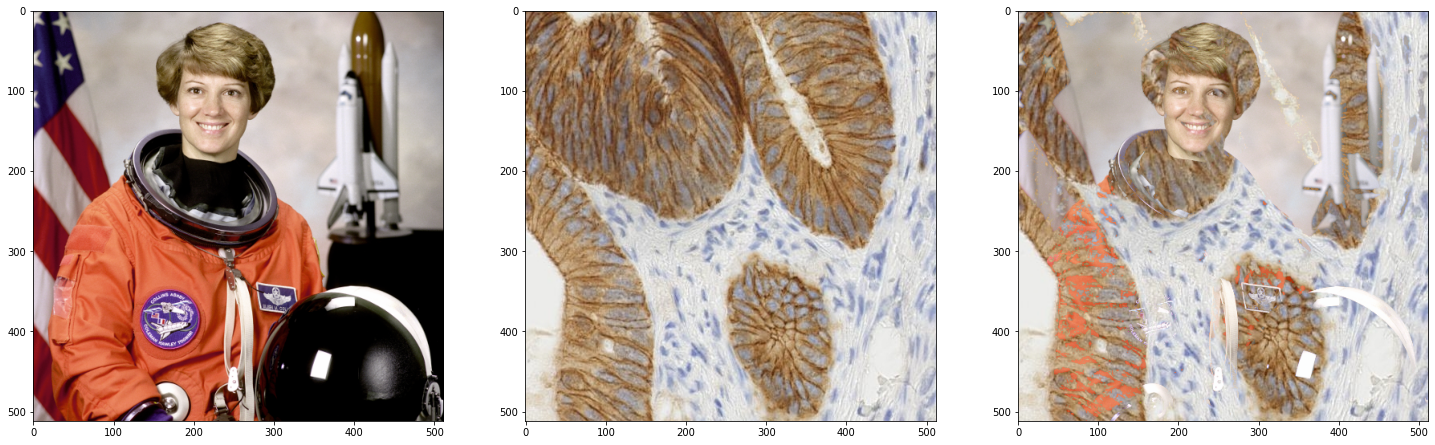

In [14]:
#@title Interactive visualisation. { run: "auto" }
def plot(img1, img2, mode, op, typeop):
  #img1, 2 as numpy
  done=False
  if type_op is "clampear":
    newimg = clamp(img1, img2, op, mode)
    done=True
  elif type_op is "promedio":
    newimg = avg(img1, img2, op, mode)
    done=True
  else:
    if mode is "yiq":
      newimg = yiqLightDark(img1, img2, ops[typeop])
      done=True
    else:
      print("Image must be in yiq")
      done=False
  if done:
    _, axarr = plt.subplots(1,3, figsize=(25,25))
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    axarr[2].imshow(newimg)

type_op = 'if-lighter' #@param ["clampear", "promedio", "if-darker", "if-lighter"]
mode = 'yiq' #@param ["rgb", "yiq"]
op = '+' #@param ["+", "-"]
plot(npast, npimm, mode, ops[op], type_op)
